# Imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import osmnx as ox
from pprint import pprint

import pyrosm

# Read data

In [4]:
folder = "01_outputs/" # note 01_outputs actually are generated after 02_outputs. So this is correct.

Gb_edges = gpd.read_file(folder + "geofabrik_bike_graph_edges_w_EDSAaccidents.geojson").set_index(["u", "v", "key"], drop = True)
Gb_nodes = gpd.read_file(folder + "geofabrik_bike_graph_nodes_w_brgycode_popdensity.geojson").set_index("osmid", drop = True)
Gw_edges = gpd.read_file(folder + "geofabrik_walk_graph_edges_w_EDSAaccidents.geojson").set_index(["u", "v", "key"], drop = True)
Gw_nodes = gpd.read_file(folder + "geofabrik_walk_graph_nodes_w_brgycode_popdensity.geojson").set_index("osmid", drop = True)

In [5]:
Gb_edges.shape, Gw_edges.shape

((14878, 159), (15332, 159))

In [6]:
Gb_edges.index.is_unique, Gw_edges.index.is_unique

(True, True)

In [7]:
assumed_crs = "4326"

city_adm3_pcode = "PH137401000"

city_initial_digits = "PH137401"

In [8]:
brgy_geo = gpd.read_file("01_outputs/CCHAIN_FILTERED_brgy_geography.geojson")

brgy_geo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   uuid                    27 non-null     object        
 1   adm4_pcode              27 non-null     object        
 2   date                    27 non-null     datetime64[ms]
 3   freq                    27 non-null     object        
 4   brgy_total_area_x       27 non-null     float64       
 5   brgy_distance_to_coast  27 non-null     float64       
 6   brgy_is_coastal         27 non-null     bool          
 7   adm1_en                 27 non-null     object        
 8   adm1_pcode              27 non-null     object        
 9   adm2_en                 27 non-null     object        
 10  adm2_pcode              27 non-null     object        
 11  adm3_en                 27 non-null     object        
 12  adm3_pcode              27 non-null     obje

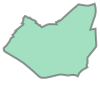

In [9]:
brgy_geo_for_city = brgy_geo.loc[brgy_geo["adm4_pcode"].str.startswith(city_initial_digits)].copy(deep = True)

city_geo = brgy_geo_for_city.union_all()
city_geo

# Check features from image data

## inspect

In [10]:
folder = "from_image_data/features/"

bike_features = pd.read_csv(folder + "bike_features.csv").set_index(["u", "v", "key"], drop = True)
# bike_scaled_features = pd.read_csv(folder + "bike_scaled_features.csv").set_index(["u", "v", "key"], drop = True)
bike_cluster_full = pd.read_csv(folder + "bike_cluster_full.csv").set_index(["u", "v", "key"], drop = True)

walk_features = pd.read_csv(folder + "walk_features.csv").set_index(["u", "v", "key"], drop = True)
# walk_scaled_features = pd.read_csv(folder + "walk_scaled_features.csv").set_index(["u", "v", "key"], drop = True)
walk_cluster_full = pd.read_csv(folder + "walk_cluster_full.csv").set_index(["u", "v", "key"], drop = True)

bike_features = bike_features.rename({col: f"FROM_IMAGES_{col}" for col in bike_features.columns}, axis = 1)
walk_features = walk_features.rename({col: f"FROM_IMAGES_{col}" for col in walk_features.columns}, axis = 1)

In [11]:
bike_cluster_full["highway"].value_counts()
# just checking to verify what highways are included

highway
residential     658
secondary       294
tertiary        198
footway         170
service          74
primary          48
trunk            44
unclassified     20
pedestrian        4
trunk_link        2
path              2
Name: count, dtype: int64

In [12]:
(bike_cluster_full["highway"] != "residential").sum()

np.int64(856)

In [13]:
walk_features.shape, bike_features.shape

((1530, 10), (1514, 10))

In [14]:
bike_features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1514 entries, (np.int64(10148578463), np.int64(10148578465), np.int64(0)) to (np.int64(9985910917), np.int64(7188588310), np.int64(0))
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   FROM_IMAGES_has_crosswalk          1514 non-null   float64
 1   FROM_IMAGES_has_traffic_sign       1514 non-null   float64
 2   FROM_IMAGES_has_traffic_light      1514 non-null   float64
 3   FROM_IMAGES_has_bicycle            1514 non-null   float64
 4   FROM_IMAGES_obstruction_density    1514 non-null   float64
 5   FROM_IMAGES_sidewalk_ratio         1514 non-null   float64
 6   FROM_IMAGES_cycling_lane_coverage  1514 non-null   float64
 7   FROM_IMAGES_greenery_ratio         1514 non-null   float64
 8   FROM_IMAGES_road_condition         1514 non-null   float64
 9   FROM_IMAGES_scene_label            1514 non-null   object 
dtypes: float6

In [15]:
walk_features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1530 entries, (np.int64(10148578463), np.int64(10148578465), np.int64(0)) to (np.int64(9985910917), np.int64(7188588310), np.int64(0))
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   FROM_IMAGES_has_crosswalk          1530 non-null   float64
 1   FROM_IMAGES_has_traffic_sign       1530 non-null   float64
 2   FROM_IMAGES_has_traffic_light      1530 non-null   float64
 3   FROM_IMAGES_has_bicycle            1530 non-null   float64
 4   FROM_IMAGES_obstruction_density    1530 non-null   float64
 5   FROM_IMAGES_sidewalk_ratio         1530 non-null   float64
 6   FROM_IMAGES_cycling_lane_coverage  1530 non-null   float64
 7   FROM_IMAGES_greenery_ratio         1530 non-null   float64
 8   FROM_IMAGES_road_condition         1530 non-null   float64
 9   FROM_IMAGES_scene_label            1530 non-null   object 
dtypes: float6

In [16]:
# # all roads have road_condition = 1 for walk and bike. Ignore.
# bike_features["road_condition"].hist()

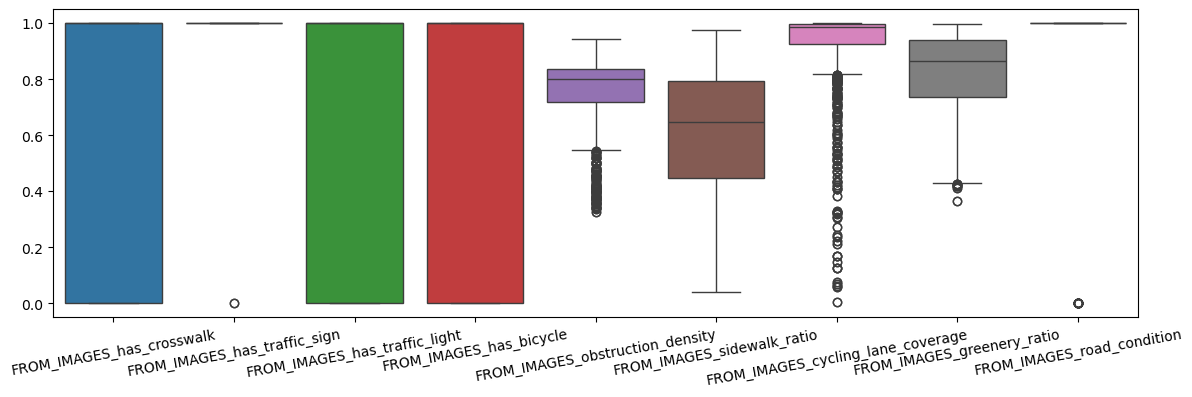

In [17]:
fig, ax = plt.subplots(figsize = (14,4))
sns.boxplot(walk_features, ax = ax)
plt.xticks(rotation=10)
plt.show()

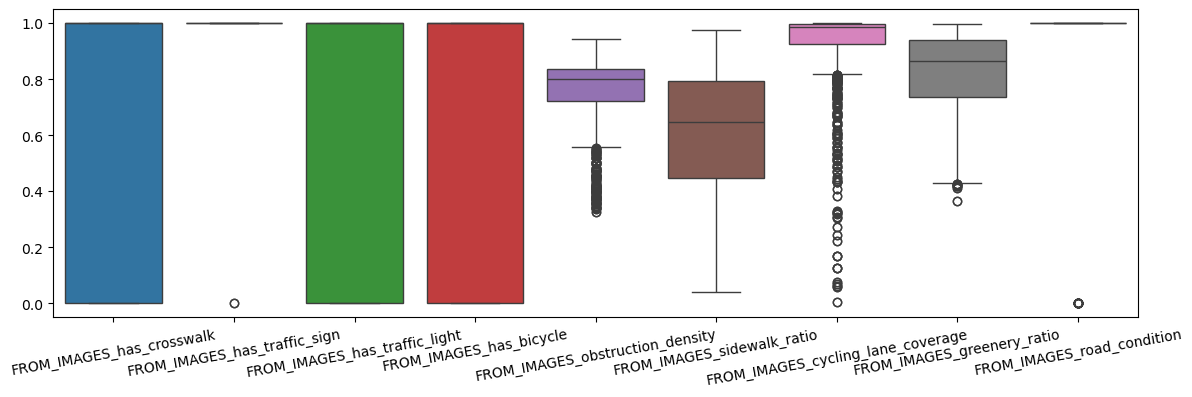

In [18]:
fig, ax = plt.subplots(figsize = (14,4))
sns.boxplot(bike_features, ax = ax)
plt.xticks(rotation=10)
plt.show()

In [19]:
walk_features["FROM_IMAGES_has_crosswalk"].value_counts()

FROM_IMAGES_has_crosswalk
1.0    852
0.0    678
Name: count, dtype: int64

In [20]:
walk_features["FROM_IMAGES_has_traffic_sign"].value_counts()

FROM_IMAGES_has_traffic_sign
1.0    1528
0.0       2
Name: count, dtype: int64

In [21]:
walk_features["FROM_IMAGES_has_traffic_light"].value_counts()

FROM_IMAGES_has_traffic_light
1.0    1108
0.0     422
Name: count, dtype: int64

In [22]:
walk_features["FROM_IMAGES_has_bicycle"].value_counts()

FROM_IMAGES_has_bicycle
1.0    934
0.0    596
Name: count, dtype: int64

In [23]:
walk_features["FROM_IMAGES_road_condition"].value_counts()

FROM_IMAGES_road_condition
1.0    1502
0.0      28
Name: count, dtype: int64

## merge

In [24]:
Gb_edges = Gb_edges.merge(bike_features, how = "left", left_index=True, right_index=True)
Gw_edges = Gw_edges.merge(walk_features, how = "left", left_index=True, right_index=True)

In [25]:
Gb_edges.columns[-20:]

Index(['TAG_bus:lanes', 'TAG_survey:name', 'TAG_source:name:mapillary',
       'TAG_public_transport', 'TAG_indoor', 'TAG_width:lanes',
       'TAG_barrier:personnel', 'TAG_bridge:structure', 'EDSA_accidents',
       'geometry', 'FROM_IMAGES_has_crosswalk', 'FROM_IMAGES_has_traffic_sign',
       'FROM_IMAGES_has_traffic_light', 'FROM_IMAGES_has_bicycle',
       'FROM_IMAGES_obstruction_density', 'FROM_IMAGES_sidewalk_ratio',
       'FROM_IMAGES_cycling_lane_coverage', 'FROM_IMAGES_greenery_ratio',
       'FROM_IMAGES_road_condition', 'FROM_IMAGES_scene_label'],
      dtype='object')

In [26]:
Gb_edges.index.is_unique, Gw_edges.index.is_unique

(True, True)

# Compute metrics from geofabrik

Plus road accident data.

## inspection

In [27]:
Gb_edges.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 14878 entries, (np.int64(321734921), np.int64(26365570), np.int32(0)) to (np.int64(6773491495), np.int64(6375475926), np.int32(0))
Columns: 169 entries, highway to FROM_IMAGES_scene_label
dtypes: datetime64[ms](2), float64(11), geometry(1), int32(3), object(152)
memory usage: 20.2+ MB


In [28]:
Gb_edges["motor_vehicle"].value_counts(ascending = False, dropna = False)

motor_vehicle
None       14762
no           102
yes            8
private        6
Name: count, dtype: int64

In [29]:
Gb_edges["motorcar"].value_counts(ascending = False, dropna = False)

motorcar
None           14468
no               346
yes               60
destination        4
Name: count, dtype: int64

In [30]:
Gb_edges["psv"].value_counts(ascending = False, dropna = False)

psv
None    14854
no         24
Name: count, dtype: int64

In [31]:
Gb_edges["width"].value_counts(ascending = False, dropna = False)

width
None    14764
3          60
5          36
4          16
2           2
Name: count, dtype: int64

In [32]:
Gb_edges["TAG_parking:lane:left:parallel"].value_counts(ascending = False, dropna = False)

TAG_parking:lane:left:parallel
None         14864
on_street       14
Name: count, dtype: int64

In [33]:
Gb_edges["TAG_parking:lane:right:parallel"].value_counts(ascending = False, dropna = False)

TAG_parking:lane:right:parallel
None         14866
on_street       12
Name: count, dtype: int64

In [34]:
Gb_edges["TAG_parking:right"].value_counts(ascending = False, dropna = False)

TAG_parking:right
None            14862
lane               12
half_on_kerb        4
Name: count, dtype: int64

In [35]:
Gb_edges["TAG_cycleway:both"].value_counts(ascending = False, dropna = False)

TAG_cycleway:both
None    14748
lane      130
Name: count, dtype: int64

In [36]:
Gb_edges["TAG_crossing"].value_counts(ascending = False, dropna = False)

TAG_crossing
None               14660
uncontrolled         134
zebra                 32
unmarked              22
marked                20
traffic_signals        6
informal               4
Name: count, dtype: int64

## edsa accidents

In [37]:
Gb_edges["EDSA_accidents"].value_counts().sort_index()

EDSA_accidents
0.0     140
1.0      12
2.0      24
3.0       2
4.0      10
5.0       2
6.0       6
7.0       2
8.0       6
10.0      6
12.0      6
18.0      6
19.0      2
26.0      4
28.0      2
62.0      2
84.0      2
Name: count, dtype: int64

In [38]:
# try scaling

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

pd.DataFrame(scaler.fit_transform(Gb_edges[["EDSA_accidents"]])).value_counts().sort_index()

0       
0.000000    140
0.011905     12
0.023810     24
0.035714      2
0.047619     10
0.059524      2
0.071429      6
0.083333      2
0.095238      6
0.119048      6
0.142857      6
0.214286      6
0.226190      2
0.309524      4
0.333333      2
0.738095      2
1.000000      2
Name: count, dtype: int64

In [39]:
Gb_edges.loc[Gb_edges["EDSA_accidents"].notna()].shape

(234, 169)

In [40]:
# decided to just have discrete levels
Gb_edges["EDSA_accident_component"] = (Gb_edges["EDSA_accidents"].fillna(0)).apply(lambda x: 0 if x <= 5 else (1 if x <= 20 else 2))
Gw_edges["EDSA_accident_component"] = (Gw_edges["EDSA_accidents"].fillna(0)).apply(lambda x: 0 if x <= 5 else (1 if x <= 20 else 2))

In [41]:
Gw_edges["EDSA_accident_component"].value_counts()

EDSA_accident_component
0    15302
1       24
2        6
Name: count, dtype: int64

In [42]:
Gb_edges["footway"].value_counts()

footway
sidewalk    850
crossing    598
link         26
alley        16
Name: count, dtype: int64

In [43]:
Gb_edges.loc[
    Gb_edges["TAG_sidewalk:right"].notna() | Gb_edges["TAG_sidewalk:left"].notna() | Gb_edges["sidewalk"].notna(), # | Gb_edges["TAG_sidewalk:both"].notna(),
    ["highway", "sidewalk", "foot", "footway", "bicycle", "cycleway", "TAG_sidewalk:right","TAG_sidewalk:left", "TAG_crossing"]# , "TAG_sidewalk:both"]
].drop_duplicates()[50:]

,,,highway,sidewalk,foot,footway,bicycle,cycleway,TAG_sidewalk:right,TAG_sidewalk:left,TAG_crossing
u,v,key,,,,,,,,,


In [44]:
col_to_check = "bicycle"

Gb_edges.loc[
    Gb_edges[col_to_check].notnull(),
    ["highway", "sidewalk", "foot", "footway", "bicycle", "cycleway",
     # "TAG_sidewalk:right","TAG_sidewalk:left", "TAG_crossing",
     "TAG_cycleway:both", "TAG_cycleway:left", "TAG_cycleway:right",
     "TAG_parking:right", "TAG_parking:both",
     col_to_check
    ]
].drop_duplicates()

highway sidewalk  foot   footway   bicycle  \
u           v           key                                                   
25583881    2184946329  0    residential     both   yes      None       yes   
            25583990    0    residential     None   yes      None       yes   
4643603438  11989063255 0     pedestrian     None  None      None       yes   
1941072488  1941072491  0           path     None   yes      None       yes   
4709293536  4709293537  0        footway     None   yes      None       yes   
7393981440  8631595463  0        service     None  None      None       yes   
320129693   6544644390  0           path     None  None      None       yes   
9980716601  9980698962  0        footway     None  None  crossing  dismount   
2466263317  2466263323  0        service     None   yes      None       yes   
4709293537  4989129991  0        footway     None  None      None       yes   
242433556   295660714   0    residential       no  None      None       yes   
            5407593489  0    residential     None  None      None       yes   
243193964   6530757314  0       tertiary     both  None      None       yes   
5820029360  5820029359  0       tertiary     None  None      None       yes   
6530757315  1467806972  0       tertiary     both  None      None       yes   
6544644394  9774074744  0        footway     None  None      None  dismount   
6533297220  6533297218  0        footway     None  None  crossing       yes   
10968838510 6773508385  0        footway     None   yes  crossing       yes   

                            cycleway TAG_cycleway:both TAG_cycleway:left  \
u           v           key                                                
25583881    2184946329  0       None              None              None   
            25583990    0       None              None              None   
4643603438  11989063255 0       None              None              None   
1941072488  1941072491  0       None              None              None   
4709293536  4709293537  0       None              None              None   
7393981440  8631595463  0       None              None              None   
320129693   6544644390  0       None              None              None   
9980716601  9980698962  0       None              None              None   
2466263317  2466263323  0       None              None              None   
4709293537  4989129991  0       None              None              None   
242433556   295660714   0       None              None              None   
            5407593489  0       None              None              None   
243193964   6530757314  0       None              None              None   
5820029360  5820029359  0       None              None              None   
6530757315  1467806972  0       None              None              None   
6544644394  9774074744  0       None              None              None   
6533297220  6533297218  0       None              None              None   
10968838510 6773508385  0       None              None              None   

                            TAG_cycleway:right TAG_parking:right  \
u           v           key                                        
25583881    2184946329  0                 None              None   
            25583990    0                 None              None   
4643603438  11989063255 0                 None              None   
1941072488  1941072491  0                 None              None   
4709293536  4709293537  0                 None              None   
7393981440  8631595463  0                 None              None   
320129693   6544644390  0                 None              None   
9980716601  9980698962  0                 None              None   
2466263317  2466263323  0                 None              None   
4709293537  4989129991  0                 None              None   
242433556   295660714   0                 None              None   
            5407593489  0                 None 

In [45]:
[col for col in Gb_edges.columns if "cycle" in col]
# TAG_cycleway:smoothness is useless; all are intermediate

['cycleway',
 'bicycle',
 'TAG_cycleway:lane',
 'TAG_cycleway:right',
 'TAG_oneway:bicycle',
 'TAG_cycleway:both',
 'TAG_motorcycle',
 'TAG_cycleway:separation:left',
 'TAG_cycleway:smoothness',
 'TAG_cycleway:left',
 'TAG_motorcycle:lanes',
 'TAG_cycleway:separation:both',
 'FROM_IMAGES_has_bicycle']

## preprocess_edge_info

In [46]:
def preprocess_edge_info(s):
    sidewalk_description = "no_sidewalk"
    has_left_sidewalk_status = False
    has_right_sidewalk_status = False
    is_crossing_status = False
    bicycle_status = "no" # yes, permissive, destination, dismount, no
    cycleway_lane_type = "no" # lane, shared_lane, no. Additional level: different (the two lanes have different lane types).
    cycleway_description = "no" # both, left, right, no, yes (meaning there is a cycleway but not sure where it is).
    cycleway_left_lane_type = "no" # lane, shared_lane, no
    cycleway_right_lane_type = "no" # lane, shared_lane, no

    cycleway_class = "no"
    cycleway_left_class = "no"
    cycleway_right_class = "no"

    # initial checks

    # cycle stuff

    if s["cycleway"] in ["lane", "shared_lane"]:
        cycleway_lane_type = s["cycleway"]
        cycleway_description = "yes"
    else:
        cycleway_lane_type = "no"
        cycleway_description = "no"

    if s["TAG_cycleway:lane"] in ["exclusive"]:
        if cycleway_lane_type in ["no"]:
            cycleway_lane_type = "lane"
        if cycleway_description in ["no"]:
            cycleway_description = "yes"
        cycleway_class = "class 2"
    elif s["TAG_cycleway:lane"] in ["advisory", "pictogram"]:
        if cycleway_lane_type in ["no"]:
            cycleway_lane_type = "lane"
        if cycleway_description in ["no"]:
            cycleway_description = "yes"
        cycleway_class = "class 3"

    if s["TAG_cycleway:both"] in ["lane", "shared_lane", "track"]:
        cycleway_lane_type = s["TAG_cycleway:both"]
        cycleway_description = "both"
        cycleway_left_lane_type = s["TAG_cycleway:both"]
        cycleway_right_lane_type = s["TAG_cycleway:both"]
        if s["TAG_cycleway:both"] in ["track"]:
            cycleway_left_class = "class 1"
            cycleway_right_class = "class 1"
        elif s["TAG_cycleway:both"] in ["lane", "shared_lane"]:
            if cycleway_class != "no":
                cycleway_left_class = cycleway_class
                cycleway_right_class = cycleway_class
            else:
                pass
    
    if s["TAG_cycleway:left"] in ["opposite_lane"]:
        cycleway_left_lane_type = "no"
    elif s["TAG_cycleway:left"] in ["lane", "shared_lane", "track"]:
        cycleway_left_lane_type = s["TAG_cycleway:left"]
        cycleway_description = "yes"
        if s["TAG_cycleway:left"] in ["track"]:
            cycleway_left_class = "class 1"
        elif s["TAG_cycleway:left"] in ["lane", "shared_lane"]:
            if cycleway_class != "no":
                cycleway_left_class = cycleway_class
            else:
                pass
    
    if s["TAG_cycleway:right"] in ["opposite_lane"]:
        cycleway_right_lane_type = "no"
    elif s["TAG_cycleway:right"] in ["lane", "shared_lane", "track"]:
        cycleway_right_lane_type = s["TAG_cycleway:right"]
        cycleway_description = "yes"
        if s["TAG_cycleway:right"] in ["track"]:
            cycleway_right_class = "class 1"
        elif s["TAG_cycleway:right"] in ["lane", "shared_lane"]:
            if cycleway_class != "no":
                cycleway_right_class = cycleway_class
            else:
                pass
    
    if (cycleway_left_lane_type != "no") and (cycleway_right_lane_type != "no"):
        if cycleway_left_lane_type == cycleway_right_lane_type:
            cycleway_lane_type = cycleway_left_lane_type
            cycleway_description = "both"
        else:
            cycleway_lane_type = "different"
            cycleway_description = "both"
    elif (cycleway_left_lane_type != "no") and (cycleway_right_lane_type == "no"):
        cycleway_lane_type = cycleway_left_lane_type
        cycleway_description = "left"
    elif (cycleway_left_lane_type == "no") and (cycleway_right_lane_type != "no"):
        cycleway_lane_type = cycleway_right_lane_type
        cycleway_description = "right"

    if (cycleway_description != "no"):
        if cycleway_lane_type in ["no"]:
            cycleway_lane_type = "lane"
        if bicycle_status in ["no"]:
            bicycle_status = "yes"

    if (cycleway_left_class != "no") and (cycleway_right_class != "no"):
        if cycleway_left_class == cycleway_right_class:
            cycleway_class = cycleway_left_class
            cycleway_description = "both"
        else:
            cycleway_class = "different"
            cycleway_description = "both"
    elif (cycleway_left_class != "no") and (cycleway_right_class == "no"):
        cycleway_class = cycleway_left_class
        cycleway_description = "left"
    elif (cycleway_left_class == "no") and (cycleway_right_class != "no"):
        cycleway_class = cycleway_right_class
        cycleway_description = "right"
    # also
    if (cycleway_left_class != "no") or (cycleway_right_class != "no"):
        if bicycle_status in ["no"]:
            bicycle_status = "yes"
        if cycleway_description in ["no"]:
            cycleway_description = "yes"

    # # last for cycle stuff

    if (cycleway_left_class in ["no"]):
        if cycleway_description in ["left"]:
            cycleway_class = "class 3"
            cycleway_left_class = "class 3"
            cycleway_right_class = "no"
        elif cycleway_description in ["both"]:
            cycleway_left_class = "class 3"

    if (cycleway_right_class in ["no"]):
        if cycleway_description in ["right"]:
            cycleway_class = "class 3"
            cycleway_left_class = "no"
            cycleway_right_class = "class 3"
        elif cycleway_description in ["both"]:
            cycleway_right_class = "class 3"

    if (cycleway_left_class == "class 3") and (cycleway_right_class == "class 3"):
        cycleway_class = "class 3"
    
    if cycleway_description in ["yes"]:
        if cycleway_class in ["no"]:
            cycleway_class = "class 3"

    if (cycleway_description != "no"):
        if (cycleway_left_lane_type == "no") and (cycleway_right_lane_type == "no"):
            cycleway_left_lane_type = "unknown_but_one_of_the_two_must_exist"
            cycleway_right_lane_type = "unknown_but_one_of_the_two_must_exist"
        if (cycleway_left_class == "no") and (cycleway_right_class == "no"):
            cycleway_left_class = "unknown_but_one_of_the_two_must_exist"
            cycleway_right_class = "unknown_but_one_of_the_two_must_exist"

    # start sidewalk stuff

    if s["sidewalk"] in ["yes"]:
        sidewalk_description = "is_sidewalk"
    elif s["sidewalk"] in ["both"]:
        sidewalk_description = "has_sidewalk"
        has_left_sidewalk_status = True
        has_right_sidewalk_status = True
    elif s["sidewalk"] in ["left"]:
        sidewalk_description = "has_sidewalk"
        has_left_sidewalk_status = True
    elif s["sidewalk"] in ["right"]:
        sidewalk_description = "has_sidewalk"
        has_right_sidewalk_status = True
    elif s["sidewalk"] in ["no"]:
        sidewalk_description = "no_sidewalk"
        has_left_sidewalk_status = False
        has_right_sidewalk_status = False

    if s["TAG_sidewalk:right"] in ["yes"]:
        sidewalk_description = "has_sidewalk"
        has_right_sidewalk_status = True
    elif s["TAG_sidewalk:right"] in ["separate"]:
        # could be it has a sidewalk on the left, or not
        has_right_sidewalk_status = False

    if s["TAG_sidewalk:left"] in ["yes"]:
        sidewalk_description = "has_sidewalk"
        has_left_sidewalk_status = True
    elif s["TAG_sidewalk:left"] in ["separate"]:
        # could be it has a sidewalk on the right, or not
        has_left_sidewalk_status = False
    
    if s["footway"] in ["sidewalk"]:
        sidewalk_description = "is_sidewalk"
    elif s["footway"] in ["crossing"]:
        is_crossing_status = True
    elif s["footway"] in ["link", "alley"]:
        # assume
        bicycle_status = "permissive"

    # last checks

    if has_left_sidewalk_status or has_right_sidewalk_status:
        sidewalk_description = "has_sidewalk"

    if sidewalk_description in ["is_sidewalk"]:
        bicycle_status = "dismount"

    if is_crossing_status is True:
        bicycle_status = "dismount"

    # force the known bicycle status to be used if it is available
    if s["bicycle"] in ["yes", "permissive", "destination", "dismount", "no"]:
        # this takes precedence over the previous inferences we made about bicycle access
        bicycle_status = s["bicycle"]

    # hard assumptions

    if (cycleway_description in ["no"]):
        if (s["bicycle"] in ["no"]) and (sidewalk_description in ["has_sidewalk"]):
            bicycle_status = "dismount"

    if (s["foot"] in ["yes", "designated"]) and (s["bicycle"] in ["no"]):
        bicycle_status = "dismount"

    if (s["highway"] in ["residential"]) and (s["bicycle"] in ["no"]):
        bicycle_status = "permissive"

    #---

    # parking subtags
    parking_left_description = "unknown"
    parking_right_description = "unknown"

    if "TAG_parking:both" in s.keys():
        if pd.notnull(s["TAG_parking:both"]):
            if s["TAG_parking:both"] in ["half_on_kerb", "lane", "no"]: # half_on_kerb as in parking that's half on the curb, half on the road; lane as in parking lane on the road itself
                parking_left_description = s["TAG_parking:both"]
                parking_right_description = s["TAG_parking:both"]
    if "TAG_parking:left" in s.keys():
        if pd.notnull(s["TAG_parking:left"]):
            if s["TAG_parking:left"] in ["half_on_kerb", "lane", "no"]: # half_on_kerb as in parking that's half on the curb, half on the road; lane as in parking lane on the road itself
                parking_left_description = s["TAG_parking:left"]
    if "TAG_parking:right" in s.keys():
        if pd.notnull(s["TAG_parking:right"]):
            if s["TAG_parking:right"] in ["half_on_kerb", "lane", "no"]: # half_on_kerb as in parking that's half on the curb, half on the road; lane as in parking lane on the road itself
                parking_right_description = s["TAG_parking:right"]
            else:
                pass
    
    # parallel parking lanes on the street
    # note, these are considered "lane" since there isn't much of a difference.
    if "TAG_parking:lane:both:parallel" in s.keys():
        if pd.notnull(s["TAG_parking:lane:both:parallel"]):
            if s["TAG_parking:lane:both:parallel"] == "on_street":
                parking_left_description = "lane"
                parking_right_description = "lane"
    if "TAG_parking:lane:left:parallel" in s.keys():
        if pd.notnull(s["TAG_parking:lane:left:parallel"]):
            if s["TAG_parking:lane:left:parallel"] == "on_street":
                parking_left_description = "lane"
    if "TAG_parking:lane:right:parallel" in s.keys():
        if pd.notnull(s["TAG_parking:lane:right:parallel"]):
            if s["TAG_parking:lane:right:parallel"] == "on_street":
                parking_right_description = "lane"

    #----------
    # COMMON to dismount and non-dismount
    if pd.notnull(s["width"]):
        width = np.float64(s["width"])
        width_comp = width - 3
        # we consider the default discomfort level to occur when width of road is 3 meters.
        # smaller width means lower discomfort.
    else:
        width_comp = 0

    # street lights
    lit_comp = {
        "yes": -1,
        "no": 0
    }.get(s["lit"], 0)

    maxspeed_comp = 0
    if pd.notnull(s["maxspeed"]):
        maxspeed = np.float64(s["maxspeed"])
        # we consider default discomfort level to occur when maxspeed is 30. The corresponding component is 0.
        if maxspeed < 30:
            maxspeed_comp = -1
        elif maxspeed > 30:
            maxspeed_comp = 1
    else:
        maxspeed_comp = 0

    segregated_comp = {
        "no": 1
    }.get(s.get("segregated", "unknown"), 0)

    crossing_tag_comp = 0
    if s["TAG_crossing"] in ["unmarked", "informal"]:
        crossing_tag_comp = 1

    # EDSA accident component
    edsa_accident_comp = s["EDSA_accident_component"] # all should be non-null in this column

    # NEW: whether motor vehicles are allowed
    motor_vehicle_comp = 0
    if pd.notnull(s["motor_vehicle"]):
        if s["motor_vehicle"] == "no":
            motor_vehicle_comp = -2
    if pd.notnull(s["motorcar"]): # motorcar is also considered here
        if s["motorcar"] == "no":
            motor_vehicle_comp = -1

    output = { # DO NOT CHANGE THE ORDER
        "sidewalk_description": sidewalk_description,
        "has_left_sidewalk_status": has_left_sidewalk_status,
        "has_right_sidewalk_status": has_right_sidewalk_status,
        "is_crossing_status": is_crossing_status,
        "bicycle_status": bicycle_status,
        "cycleway_lane_type": cycleway_lane_type,
        "cycleway_description": cycleway_description,
        "cycleway_left_lane_type": cycleway_left_lane_type,
        "cycleway_right_lane_type": cycleway_right_lane_type,
        "cycleway_class": cycleway_class,
        "cycleway_left_class": cycleway_left_class,
        "cycleway_right_class": cycleway_right_class,

        "parking_left_description": parking_left_description,
        "parking_right_description": parking_right_description,

        "width_comp": width_comp,
        "lit_comp": lit_comp,
        "maxspeed_comp": maxspeed_comp,
        "segregated_comp": segregated_comp,
        "crossing_tag_comp": crossing_tag_comp,
        "edsa_accident_comp": edsa_accident_comp,
        "motor_vehicle_comp": motor_vehicle_comp
    }

    return pd.Series(output)

In [47]:
preproc_Gb = Gb_edges.apply(preprocess_edge_info, axis = 1).sort_index() # sorting is necessary to make lookup faster
preproc_Gw = Gw_edges.apply(preprocess_edge_info, axis = 1).sort_index()

preproc_Gb.head()

sidewalk_description  has_left_sidewalk_status  \
u        v          key                                                  
12067613 8595216694 0            no_sidewalk                     False   
12067619 1276924654 0            no_sidewalk                     False   
         6970838871 0            no_sidewalk                     False   
12067627 5289211747 0            no_sidewalk                     False   
         5289211749 0            no_sidewalk                     False   

                         has_right_sidewalk_status  is_crossing_status  \
u        v          key                                                  
12067613 8595216694 0                        False               False   
12067619 1276924654 0                        False               False   
         6970838871 0                        False               False   
12067627 5289211747 0                        False               False   
         5289211749 0                        False               False   

                        bicycle_status cycleway_lane_type  \
u        v          key                                     
12067613 8595216694 0              yes               lane   
12067619 1276924654 0               no                 no   
         6970838871 0               no                 no   
12067627 5289211747 0              yes               lane   
         5289211749 0              yes               lane   

                        cycleway_description cycleway_left_lane_type  \
u        v          key                                                
12067613 8595216694 0                  right                      no   
12067619 1276924654 0                     no                      no   
         6970838871 0                     no                      no   
12067627 5289211747 0                  right                      no   
         5289211749 0                  right                      no   

                        cycleway_right_lane_type cycleway_class  ...  \
u        v          key                                          ...   
12067613 8595216694 0                       lane        class 3  ...   
12067619 1276924654 0                         no             no  ...   
         6970838871 0                         no             no  ...   
12067627 5289211747 0                       lane        class 3  ...   
         5289211749 0                       lane        class 3  ...   

                        cycleway_right_class parking_left_description  \
u        v          key                                                 
12067613 8595216694 0                class 3                  unknown   
12067619 1276924654 0                     no                  unknown   
         6970838871 0                     no                  unknown   
12067627 5289211747 0                class 3                  unknown   
         5289211749 0                class 3                  unknown   

                        parking_right_description width_comp  lit_comp  \
u        v          key                                                  
12067613 8595216694 0                     unknown        0.0        -1   
12067619 1276924654 0                     unknown        0.0        -1   
         6970838871 0                     unknown        0.0         0   
12067627 5289211747 0                     unknown        0.0        -1   
         5289211749 0                     unknown        0.0        -1   

                         maxspeed_comp  segregated_comp  crossing_tag_comp  \
u        v          key                                                      
12067613 8595216694 0                1                0                  0   
12067619 1276924654 0                1                0                  0   
         6970838871 0                0                0                  0   
12067627 5289211747 0                1                0                  0   
         5289211749 0                1           

In [48]:
preproc_Gb.columns

Index(['sidewalk_description', 'has_left_sidewalk_status',
       'has_right_sidewalk_status', 'is_crossing_status', 'bicycle_status',
       'cycleway_lane_type', 'cycleway_description', 'cycleway_left_lane_type',
       'cycleway_right_lane_type', 'cycleway_class', 'cycleway_left_class',
       'cycleway_right_class', 'parking_left_description',
       'parking_right_description', 'width_comp', 'lit_comp', 'maxspeed_comp',
       'segregated_comp', 'crossing_tag_comp', 'edsa_accident_comp',
       'motor_vehicle_comp'],
      dtype='object')

In [49]:
preproc_Gb.index.is_unique, preproc_Gw.index.is_unique

(True, True)

### export preprocessed edges

In [50]:
preproc_Gb.to_csv("04_outputs/preproc_Gb.csv", index = True)
preproc_Gw.to_csv("04_outputs/preproc_Gw.csv", index = True)

## biking_discomfort REVISED

In [112]:
def biking_discomfort(s, weights, weights_main_components):
    """Compute biking discomfort for a row from a dataframe of edges.
    
s: Series. The row.

weights: dict. Keys should be same as column names of dataframe.
"""

    # get variables from other function
    sidewalk_description, has_left_sidewalk_status, has_right_sidewalk_status, is_crossing_status, bicycle_status, cycleway_lane_type, cycleway_description, cycleway_left_lane_type, cycleway_right_lane_type, cycleway_class, cycleway_left_class, cycleway_right_class, parking_left_description, parking_right_description, width_comp, lit_comp, maxspeed_comp, segregated_comp, crossing_tag_comp, edsa_accident_comp, motor_vehicle_comp = preproc_Gb.loc[s.name].values

    #----------
    # DISMOUNT

    # sidewalk_description: is_sidewalk, has_sidewalk
    # note to self: being-a-bike-lane should always be scored negatively

    if bicycle_status == "dismount":

        foot_comp = {
            "yes": -2,
            "designated": -1,
            "use_sidepath": 2,
        }.get(s["foot"], 0)

        # alley_comp replaces footway_comp, service_comp for Gb
        is_alley_status = (s["footway"] == "alley") or (s["service"] == "alley")
        alley_comp = -1 if is_alley_status else 0

        highway_comp = {
            "footway": -4,
            "pedestrian": -3,
            "living_street": -2,
            "path": -1,
            "residential": -0.5,
        }.get(s["highway"], 0)

        # sidewalk
        sidewalk_comp = 0
        if has_left_sidewalk_status:
            sidewalk_comp -= 1
        if has_right_sidewalk_status:
            sidewalk_comp -= 1

        parking_subtags_comp = 0
        parking_subtags_comp += {
            "no": -0.5,
            "half_on_kerb": 1,
            "lane": 0.5
        }.get(parking_left_description, 0)
        parking_subtags_comp += {
            "no": -0.5,
            "half_on_kerb": 1,
            "lane": 0.5
        }.get(parking_right_description, 0)

        # FROM IMAGE DATA
        greenery_ratio_comp = 0
        if pd.notnull(s["FROM_IMAGES_greenery_ratio"]):
            greenery_ratio_comp = s["FROM_IMAGES_greenery_ratio"] - 1

        # other that weren't considered for dismount
        bicycle_comp = 0
        cycleway_class_comp = 0
        cycleway_lane_type_comp = 0
        cycling_lane_coverage_comp = 0
        has_bicycle_comp = 0
        road_condition_comp = 0


    # -------
    # NON-DISMOUNT, can ride bike

    # elif bicycle_status in ("yes", "permissive", "destination", "no"):
    else:

        bicycle_comp = {
            "yes": -3,
            "permissive": -2,
            "destination": -1,
            # note that "no" here is not the actual value "no" but the default value for the bicycle info variable
        }.get(bicycle_status, 0)
        # check actual value of bicycle
        if s["bicycle"] == "no":
            bicycle_comp = 3

        cycleway_class_comp = 0
        cycleway_class_comp += {
            "class 3": -1,
            "class 2": -2,
            "class 1": -4,
            "unknown_but_one_of_the_two_must_exist": -1
        }.get(cycleway_left_class, 0)
        cycleway_class_comp += {
            "class 3": -1,
            "class 2": -2,
            "class 1": -4,
            "unknown_but_one_of_the_two_must_exist": -1
        }.get(cycleway_right_class, 0)

        cycleway_lane_type_comp = 0
        cycleway_lane_type_comp += {
            "lane": -1,
            "shared_lane": 1,
            "unknown_but_one_of_the_two_must_exist": -1
        }.get(cycleway_left_lane_type, 0)
        cycleway_lane_type_comp += {
            "lane": -1,
            "shared_lane": 1,
            "unknown_but_one_of_the_two_must_exist": -1
        }.get(cycleway_right_lane_type, 0)

        foot_comp = {
            "yes": 1,
            "designated": 2,
        }.get(s["foot"], 0)

        # alley_comp replaces footway_comp, service_comp for Gb
        is_alley_status = (s["footway"] == "alley") or (s["service"] == "alley")
        alley_comp = 1 if is_alley_status else 0

        highway_comp = {
            "footway": -2,
            "pedestrian": -3,
            "living_street": -4,
            "path": -1,
            "residential": -0.5,
        }.get(s["highway"], 0)

        parking_subtags_comp = 0
        parking_subtags_comp += {
            "no": -1,
            "half_on_kerb": 0.5,
            "lane": 1
        }.get(parking_left_description, 0)
        parking_subtags_comp += {
            "no": -1,
            "half_on_kerb": 0.5,
            "lane": 1
        }.get(parking_right_description, 0)

        # FROM IMAGE DATA
        cycling_lane_coverage_comp = 0
        if pd.notnull(s["FROM_IMAGES_cycling_lane_coverage"]):
            cycling_lane_coverage_comp = s["FROM_IMAGES_cycling_lane_coverage"] - 1 # Subtract 1 because range is 0-1. Should be negative.
        
        greenery_ratio_comp = 0
        if pd.notnull(s["FROM_IMAGES_greenery_ratio"]):
            greenery_ratio_comp = s["FROM_IMAGES_greenery_ratio"] - 1

        has_bicycle_comp = 0
        if pd.notnull(s["FROM_IMAGES_has_bicycle"]):
            has_bicycle_comp = s["FROM_IMAGES_has_bicycle"] - 1

        road_condition_comp = 0
        if pd.notnull(s["FROM_IMAGES_road_condition"]):
            road_condition_comp = (s["FROM_IMAGES_road_condition"] - 1)

        # other that weren't considered for non-dismount
        sidewalk_comp = 0

    #---
    # final part

    dismount_comp = 10 if bicycle_status == "dismount" else 0

    subcomponent_dict_UNWEIGHTED = {
        "bicycle": bicycle_comp,
        "CYCLEWAY_CLASS": cycleway_class_comp,
        "CYCLEWAY_LANE_TYPE": cycleway_lane_type_comp,
        "foot": foot_comp,
        "highway": highway_comp,
        "ALLEY": alley_comp,
        "width": width_comp,
        "lit": lit_comp,
        "maxspeed": maxspeed_comp,
        "segregated": segregated_comp,
        "sidewalk": sidewalk_comp,
        "PARKING_SUBTAGS": parking_subtags_comp,
        "TAG_crossing": crossing_tag_comp,
        "EDSA_accident_component": edsa_accident_comp,
        "motor_vehicle": motor_vehicle_comp,

        # FROM IMAGE DATA
        "FROM_IMAGES_cycling_lane_coverage": cycling_lane_coverage_comp,
        "FROM_IMAGES_greenery_ratio": greenery_ratio_comp,
        "FROM_IMAGES_has_bicycle": has_bicycle_comp,
        "FROM_IMAGES_road_condition": road_condition_comp,
    }

    subcomponent_dict_WEIGHTED = {subcomponent_name: (value * weights.get(subcomponent_name, 1))
                                  for subcomponent_name, value in subcomponent_dict_UNWEIGHTED.items()}
    subcomponent_dict_WEIGHTED["DISMOUNT"] = dismount_comp

    main_component_dict_UNWEIGHTED_reference = {
        # the ff are based on the Feature groupings document
        "DISMOUNT": ("DISMOUNT", ),
        "convenience": ("bicycle", "ALLEY", "segregated", "PARKING_SUBTAGS", "foot", "FROM_IMAGES_road_condition"),
        "attractiveness": ("FROM_IMAGES_greenery_ratio", ),
        "traffic_safety": ("CYCLEWAY_CLASS", "CYCLEWAY_LANE_TYPE", "FROM_IMAGES_cycling_lane_coverage", "width", "maxspeed"),
        "security": ("lit", "FROM_IMAGES_has_bicycle"),

        # the ff are additional main components added in order to be able to use all of the subcomponents
        "accident_risk": ("EDSA_accident_component", ),
        "traffic_volume": ("highway", "motor_vehicle"),
        "safety_of_sidewalks_and_crossings": ("sidewalk", "TAG_crossing"),
    }

    main_component_dict_UNWEIGHTED = {
        key: sum([subcomponent_dict_WEIGHTED[subcomp] for subcomp in l]) # take the sum of the WEIGHTED versions of the subcomponents, in order to get the UNweighted main component.
        for key, l
        in main_component_dict_UNWEIGHTED_reference.items()
    }

    main_component_dict_WEIGHTED = {main_component_name: value * weights_main_components[main_component_name] for main_component_name, value in main_component_dict_UNWEIGHTED.items()}

    score1 = sum(main_component_dict_WEIGHTED.values())
    score2 = sum(subcomponent_dict_WEIGHTED.values())

    # breakdown_dict = {
    #     "subcomponent_dict_WEIGHTED": subcomponent_dict_WEIGHTED,
    #     "subcomponent_dict_UNWEIGHTED": subcomponent_dict_UNWEIGHTED,
    #     "main_component_dict_WEIGHTED": main_component_dict_WEIGHTED,
    #     "main_component_dict_UNWEIGHTED": main_component_dict_UNWEIGHTED
    # }

    output_dict = {
        "score_weighted_by_main": score1,
        "score_weighted_by_sub": score2,
        # "breakdown_dict": breakdown_dict
    }

    output_dict.update({f"SW_{key}": value for key, value in subcomponent_dict_WEIGHTED.items()})
    output_dict.update({f"SU_{key}": value for key, value in subcomponent_dict_UNWEIGHTED.items()})
    output_dict.update({f"MW_{key}": value for key, value in main_component_dict_WEIGHTED.items()})
    output_dict.update({f"MU_{key}": value for key, value in main_component_dict_UNWEIGHTED.items()})

    output = pd.Series(output_dict)

    return output

In [113]:
s1 = preproc_Gb.iloc[0]

preproc_Gb.loc[s1.name]

sidewalk_description         no_sidewalk
has_left_sidewalk_status           False
has_right_sidewalk_status          False
is_crossing_status                 False
bicycle_status                       yes
cycleway_lane_type                  lane
cycleway_description               right
cycleway_left_lane_type               no
cycleway_right_lane_type            lane
cycleway_class                   class 3
cycleway_left_class                   no
cycleway_right_class             class 3
parking_left_description         unknown
parking_right_description        unknown
width_comp                           0.0
lit_comp                              -1
maxspeed_comp                          1
segregated_comp                        0
crossing_tag_comp                      0
edsa_accident_comp                     0
motor_vehicle_comp                     0
Name: (12067613, 8595216694, 0), dtype: object

### weights: bike

In [133]:
# by default, set them to 1
default_weights_Gb_CYCLE = {
    "bicycle": 1,
    "CYCLEWAY_CLASS": 1,
    "CYCLEWAY_LANE_TYPE": 1,
    "foot": 1,
    "highway": 1,
    "ALLEY": 1,
    "width": 1,
    "lit": 1,
    "maxspeed": 1,
    "segregated": 1,
    "PARKING_SUBTAGS": 1,
    "TAG_crossing": 1,
    "EDSA_accident_component": 1,
    "motor_vehicle": 1,

    # FROM IMAGE DATA
    "FROM_IMAGES_cycling_lane_coverage": 1,
    "FROM_IMAGES_greenery_ratio": 1,
    "FROM_IMAGES_has_bicycle": 1,
    "FROM_IMAGES_road_condition": 1,
}

default_weights_Gb_DISMOUNT = {
    "foot": 1,
    "highway": 1,
    "ALLEY": 1,
    "width": 1,
    "lit": 1,
    "maxspeed": 1,
    "segregated": 1,
    "sidewalk": 1,
    "PARKING_SUBTAGS": 1,
    "TAG_crossing": 1,
    "EDSA_accident_component": 1,
    "motor_vehicle": 1,

    # FROM IMAGE DATA
    "FROM_IMAGES_greenery_ratio": 1,
}

default_weights_main_components_Gb = {
    "DISMOUNT": 1,
    "convenience": 1,
    "attractiveness": 1,
    "traffic_safety": 1,
    "security": 1,

    "accident_risk": 1,
    "traffic_volume": 1,
    "safety_of_sidewalks_and_crossings": 1,
}

#---

# experimental: change particular weights
weights_Gb_CYCLE = {}
weights_Gb_CYCLE.update(default_weights_Gb_CYCLE)
weights_Gb_CYCLE.update(
    {
        "bicycle": 107,
        "CYCLEWAY_CLASS": 30,
        "CYCLEWAY_LANE_TYPE": 1,
        "foot": 1,
        "highway": 23,
        "ALLEY": 1,
        "width": 1,
        "lit": 92,
        "maxspeed": 1,
        "segregated": 1,
        "PARKING_SUBTAGS": 1,
        "TAG_crossing": 1,
        "EDSA_accident_component": 1,
        "motor_vehicle": 1,

        # FROM IMAGE DATA
        "FROM_IMAGES_cycling_lane_coverage": 1,
        "FROM_IMAGES_greenery_ratio": 37,
        "FROM_IMAGES_has_bicycle": 1,
        "FROM_IMAGES_road_condition": 1,
    }
)

weights_Gb_DISMOUNT = {}
weights_Gb_DISMOUNT.update(default_weights_Gb_CYCLE)
weights_Gb_DISMOUNT.update(
    {
        "foot": 16,
        "highway": 55,
        "ALLEY": 3,
        "width": 1,
        "lit": 74,
        "maxspeed": 22,
        "segregated": 1,
        "sidewalk": 40,
        "PARKING_SUBTAGS": 1,
        "TAG_crossing": 1,
        "EDSA_accident_component": 1,
        "motor_vehicle": 1,

        # FROM IMAGE DATA
        "FROM_IMAGES_greenery_ratio": 1,
    }
)

# experimental: change particular weights for main components
weights_main_components_Gb = {}
weights_main_components_Gb.update(default_weights_main_components_Gb)
weights_main_components_Gb.update(
    {
        "DISMOUNT": 1,
        "convenience": 1,
        "attractiveness": 1,
        "traffic_safety": 1,
        "security": 1,

        "accident_risk": 1,
        "traffic_volume": 1,
        "safety_of_sidewalks_and_crossings": 1,
    }
)

In [270]:
scaler1 = MinMaxScaler((1, 2))

In [271]:
weights_Gb_CYCLE = pd.DataFrame({"weights": pd.Series(weights_Gb_CYCLE)})
weights_Gb_CYCLE = pd.Series(
    scaler1.fit_transform(weights_Gb_CYCLE).ravel(),
    index = weights_Gb_CYCLE.index
)

weights_Gb_DISMOUNT = pd.DataFrame({"weights": pd.Series(weights_Gb_DISMOUNT)})
weights_Gb_DISMOUNT = pd.Series(
    scaler1.fit_transform(weights_Gb_DISMOUNT).ravel(),
    index = weights_Gb_DISMOUNT.index
)
weights_Gb_DISMOUNT

bicycle                              1.000000
CYCLEWAY_CLASS                       1.000000
CYCLEWAY_LANE_TYPE                   1.000000
foot                                 1.205479
highway                              1.739726
ALLEY                                1.027397
width                                1.000000
lit                                  2.000000
maxspeed                             1.287671
segregated                           1.000000
PARKING_SUBTAGS                      1.000000
TAG_crossing                         1.000000
EDSA_accident_component              1.000000
motor_vehicle                        1.000000
FROM_IMAGES_cycling_lane_coverage    1.000000
FROM_IMAGES_greenery_ratio           1.000000
FROM_IMAGES_has_bicycle              1.000000
FROM_IMAGES_road_condition           1.000000
sidewalk                             1.534247
dtype: float64

In [272]:
def APPLY_BY_ROW_biking_discomfort(s):
    is_dismount = (preproc_Gb.loc[s.name]["bicycle_status"] == "dismount")
    
    # # for verification only
    # if is_dismount:
    #     print("Dismount")
    
    return biking_discomfort(
        s,
        weights = weights_Gb_DISMOUNT if is_dismount else weights_Gb_CYCLE,
        weights_main_components = weights_main_components_Gb,
    )

In [273]:
test_Gb = Gb_edges.apply(
    APPLY_BY_ROW_biking_discomfort,
    axis = 1
).merge(preproc_Gb, left_index = True, right_index = True).merge(Gb_edges[["highway", "foot", "footway", "bicycle", "cycleway"]], left_index = True, right_index = True)

In [274]:
test_Gb.shape

(14878, 83)

<Axes: >

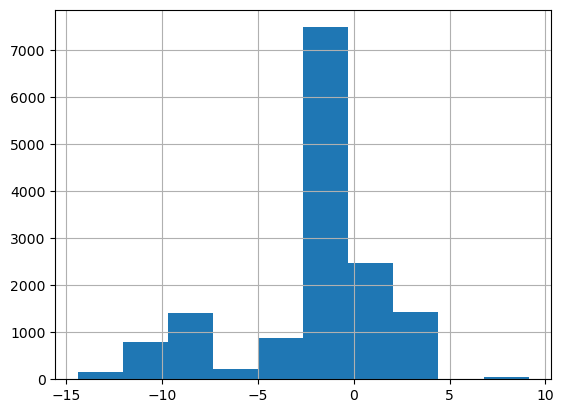

In [275]:
score_to_check = "score_weighted_by_main"

test_discomfort_b = test_Gb[score_to_check]

test_discomfort_b.hist()

### inspect data

In [276]:
Gb_edges.loc[Gb_edges["bicycle"] == "dismount"].shape

(34, 170)

In [277]:
# # subcomponents, unweighted
# df = test_Gb[["score_weighted_by_main", "score_weighted_by_sub"] + [col for col in test_Gb.columns if col.startswith("SU_")]]
df = test_Gb

df.columns

Index(['score_weighted_by_main', 'score_weighted_by_sub', 'SW_bicycle',
       'SW_CYCLEWAY_CLASS', 'SW_CYCLEWAY_LANE_TYPE', 'SW_foot', 'SW_highway',
       'SW_ALLEY', 'SW_width', 'SW_lit', 'SW_maxspeed', 'SW_segregated',
       'SW_sidewalk', 'SW_PARKING_SUBTAGS', 'SW_TAG_crossing',
       'SW_EDSA_accident_component', 'SW_motor_vehicle',
       'SW_FROM_IMAGES_cycling_lane_coverage', 'SW_FROM_IMAGES_greenery_ratio',
       'SW_FROM_IMAGES_has_bicycle', 'SW_FROM_IMAGES_road_condition',
       'SW_DISMOUNT', 'SU_bicycle', 'SU_CYCLEWAY_CLASS',
       'SU_CYCLEWAY_LANE_TYPE', 'SU_foot', 'SU_highway', 'SU_ALLEY',
       'SU_width', 'SU_lit', 'SU_maxspeed', 'SU_segregated', 'SU_sidewalk',
       'SU_PARKING_SUBTAGS', 'SU_TAG_crossing', 'SU_EDSA_accident_component',
       'SU_motor_vehicle', 'SU_FROM_IMAGES_cycling_lane_coverage',
       'SU_FROM_IMAGES_greenery_ratio', 'SU_FROM_IMAGES_has_bicycle',
       'SU_FROM_IMAGES_road_condition', 'MW_DISMOUNT', 'MW_convenience',
       'MW_attrac

In [278]:
# df[['sidewalk_description', 'has_left_sidewalk_status',
#        'has_right_sidewalk_status', 'bicycle_status', 'cycleway_lane_type',
#        'cycleway_description', 'cycleway_left_lane_type',
#        'cycleway_right_lane_type', 'cycleway_class', 'cycleway_left_class',
#        'cycleway_right_class', 'parking_left_description',
#        'parking_right_description', 'width_comp', 'lit_comp', 'maxspeed_comp',
#        'segregated_comp', 'crossing_tag_comp', 'edsa_accident_comp',
#        'motor_vehicle_comp']].value_counts().head(20)

In [279]:
# df.loc[
#     df["bicycle_status"] == "dismount",
#     ['highway', 'foot', 'footway', 'bicycle', 'cycleway',
     
#        'sidewalk_description', 'has_left_sidewalk_status',
#        'has_right_sidewalk_status', 'is_crossing_status', 'bicycle_status', 'cycleway_lane_type',
#        'cycleway_description', 'cycleway_left_lane_type',
#        'cycleway_right_lane_type', 'cycleway_class', 'cycleway_left_class',
#        'cycleway_right_class', 'parking_left_description',
#        'parking_right_description', 'width_comp', 'lit_comp', 'maxspeed_comp',
#        'segregated_comp', 'crossing_tag_comp', 'edsa_accident_comp',
#        'motor_vehicle_comp']
# ].value_counts(dropna = False)

In [280]:
df["MU_DISMOUNT"].value_counts()

MU_DISMOUNT
0.0     13388
10.0     1490
Name: count, dtype: int64

In [281]:
df.sort_values("score_weighted_by_sub", ascending = False).head(df.shape[0] // 2)["MU_DISMOUNT"].value_counts()

MU_DISMOUNT
0.0     5949
10.0    1490
Name: count, dtype: int64

### maps

In [282]:
preproc_Gb

sidewalk_description  has_left_sidewalk_status  \
u           v           key                                                  
12067613    8595216694  0            no_sidewalk                     False   
12067619    1276924654  0            no_sidewalk                     False   
            6970838871  0            no_sidewalk                     False   
12067627    5289211747  0            no_sidewalk                     False   
            5289211749  0            no_sidewalk                     False   
...                                          ...                       ...   
12233693923 12233693922 0            no_sidewalk                     False   
            12233693924 0            no_sidewalk                     False   
12233693924 5831452914  0           has_sidewalk                     False   
            11664682738 0           has_sidewalk                     False   
            12233693923 0            no_sidewalk                     False   

                             has_right_sidewalk_status  is_crossing_status  \
u           v           key                                                  
12067613    8595216694  0                        False               False   
12067619    1276924654  0                        False               False   
            6970838871  0                        False               False   
12067627    5289211747  0                        False               False   
            5289211749  0                        False               False   
...                                                ...                 ...   
12233693923 12233693922 0                        False               False   
            12233693924 0                        False               False   
12233693924 5831452914  0                         True               False   
            11664682738 0                         True               False   
            12233693923 0                        False               False   

                            bicycle_status cycleway_lane_type  \
u           v           key                                     
12067613    8595216694  0              yes               lane   
12067619    1276924654  0               no                 no   
            6970838871  0               no                 no   
12067627    5289211747  0              yes               lane   
            5289211749  0              yes               lane   
...                                    ...                ...   
12233693923 12233693922 0               no                 no   
            12233693924 0               no                 no   
12233693924 5831452914  0               no                 no   
            11664682738 0               no                 no   
            12233693923 0               no                 no   

                            cycleway_description cycleway_left_lane_type  \
u           v           key                                                
12067613    8595216694  0                  right                      no   
12067619    1276924654  0                     no                      no   
            6970838871  0                     no                      no   
12067627    5289211747  0                  right                      no   
            5289211749  0                  right                      no   
...                                          ...                     ...   
12233693923 12233693922 0                     no                      no   
            12233693924 0                     no                      no   
12233693924 5831452914  0                     no                      no   
            11664682738 0                     no                      no   
            12233693923 0                     no                      no   

                            cycleway_right_lane_type cycleway_class  ...  \
u           v           key                                          ...   
12067613   

In [326]:
## this is in case i want a palette centered at a particular value

import matplotlib.colors as colors

vmin = (-test_discomfort_b).min()
vmax = (-test_discomfort_b).max()

norm = colors.TwoSlopeNorm(vmin=vmin,
                           vcenter=(-test_discomfort_b).median(),
                           vmax=vmax)

# color palette for visualizing walking/biking discomfort
chosen_cmap = sns.diverging_palette(10, 145, center = "light",
                                    s = 100, # maximize saturation of end-colors, important for visibility
                                    sep = 1, # make the intermediate region very small so that small differences can be seen color-wise
                                    as_cmap = True)

# chosen_cmap = sns.color_palette("viridis", as_cmap = True)

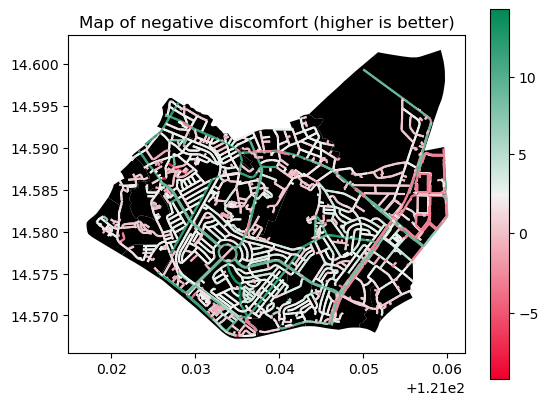

In [327]:
fig, ax = plt.subplots()

# city
brgy_geo_for_city.plot(aspect = 1, ax = ax, color = "black")

# plot the edges
Gb_edges.plot(
    (-test_discomfort_b),
    aspect = 1, ax = ax, legend = True,
    cmap = chosen_cmap,

    # use the norm
    norm = norm,
    vmin = vmin, vmax = vmax
    )


plt.title("Map of negative discomfort (higher is better)")
plt.show()

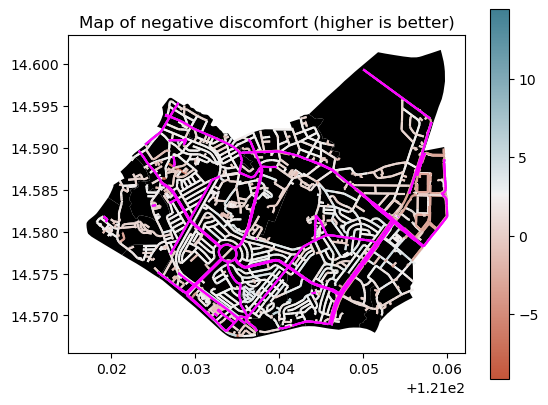

In [317]:
fig, ax = plt.subplots()

# city
brgy_geo_for_city.plot(aspect = 1, ax = ax, color = "black")

# thing being tested
Gb_edges.plot(-test_discomfort_b, aspect = 1, ax = ax, legend = True, cmap = chosen_cmap)

# ALL BIKE LANES
Gb_edges.loc[
    Gb_edges["cycleway"].isin(["lane", "shared_lane"])
    | Gb_edges["bicycle"].isin(["yes", "permissive"])
    | Gb_edges["TAG_cycleway:right"].isin(["lane", "shared_lane", "track"])
    | Gb_edges["TAG_cycleway:left"].isin(["lane", "shared_lane", "track"])
    | Gb_edges["TAG_cycleway:both"].isin(["lane", "shared_lane", "track"])
    | Gb_edges["TAG_cycleway:lane"].isin(["exclusive", "advisory", "pictogram"])
].plot(aspect = 1, ax = ax, color = "magenta")

plt.title("Map of negative discomfort (higher is better)")
plt.show()

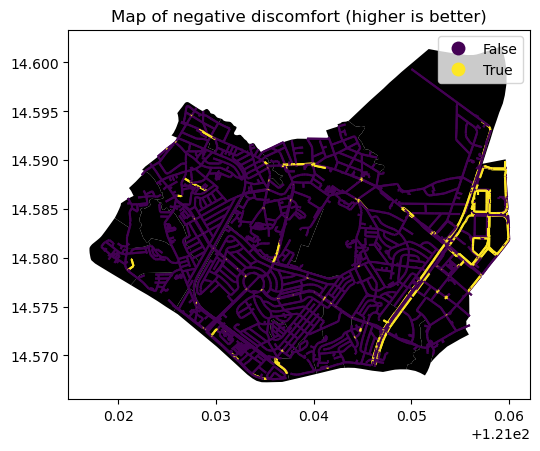

In [184]:
fig, ax = plt.subplots()

# city
brgy_geo_for_city.plot(aspect = 1, ax = ax, color = "black")

# thing being tested
Gb_edges.plot(preproc_Gb["bicycle_status"] == "dismount", aspect = 1, ax = ax, legend = True, cmap = chosen_cmap)

# Gb_edges.loc[Gb_edges["cycleway"].isin(["lane", "shared_lane"])].plot(aspect = 1, ax = ax, color = "red")

plt.title("Map of negative discomfort (higher is better)")
plt.show()

## walking_discomfort REVISED

In [231]:
def walking_discomfort(s, weights, weights_main_components):
    """Compute walking discomfort for a row from a dataframe of edges.
    
s: Series. The row.

weights: dict. Keys should be same as column names of dataframe.
"""

    # get variables from other function
    sidewalk_description, has_left_sidewalk_status, has_right_sidewalk_status, is_crossing_status, bicycle_status, cycleway_lane_type, cycleway_description, cycleway_left_lane_type, cycleway_right_lane_type, cycleway_class, cycleway_left_class, cycleway_right_class, parking_left_description, parking_right_description, width_comp, lit_comp, maxspeed_comp, segregated_comp, crossing_tag_comp, edsa_accident_comp, motor_vehicle_comp = preproc_Gw.loc[s.name].values

    foot_comp = {
        "yes": -2,
        "designated": -1,
        "use_sidepath": 2,
    }.get(s["foot"], 0)

    # alley_comp replaces footway_comp, service_comp for Gb
    is_alley_status = (s["footway"] == "alley") or (s["service"] == "alley")
    alley_comp = -1 if is_alley_status else 0

    highway_comp = {
        "footway": -4,
        "pedestrian": -3,
        "living_street": -2,
        "path": -1,
        "residential": -0.5,
        "steps": 1,
    }.get(s["highway"], 0)

    # sidewalk
    sidewalk_comp = 0
    if has_left_sidewalk_status:
        sidewalk_comp -= 1
    if has_right_sidewalk_status:
        sidewalk_comp -= 1

    parking_subtags_comp = 0
    parking_subtags_comp += {
        "no": -0.5,
        "half_on_kerb": 1,
        "lane": 0.5
    }.get(parking_left_description, 0)
    parking_subtags_comp += {
        "no": -0.5,
        "half_on_kerb": 1,
        "lane": 0.5
    }.get(parking_right_description, 0)

    # FROM IMAGE DATA

    sidewalk_ratio_comp = 0
    if pd.notnull(s["FROM_IMAGES_sidewalk_ratio"]):
        sidewalk_ratio_comp = s["FROM_IMAGES_sidewalk_ratio"] - 1
    
    greenery_ratio_comp = 0
    if pd.notnull(s["FROM_IMAGES_greenery_ratio"]):
        greenery_ratio_comp = s["FROM_IMAGES_greenery_ratio"] - 1

    # has_traffic_sign_comp = 0
    # if pd.notnull(s["FROM_IMAGES_has_traffic_sign"]):
    #     has_traffic_sign_comp = (s["FROM_IMAGES_has_traffic_sign"] - 1) * 0.5

    road_condition_comp = 0
    if pd.notnull(s["FROM_IMAGES_road_condition"]):
        road_condition_comp = (s["FROM_IMAGES_road_condition"] - 1)

    has_traffic_light_comp = 0
    if pd.notnull(s["FROM_IMAGES_has_traffic_light"]):
        has_traffic_light_comp = (s["FROM_IMAGES_has_traffic_light"] - 1) * 0.5

    has_crosswalk_comp = 0
    if pd.notnull(s["FROM_IMAGES_has_crosswalk"]):
        has_crosswalk_comp = (s["FROM_IMAGES_has_crosswalk"] - 1)

    obstruction_density_comp = 0
    if pd.notnull(s["FROM_IMAGES_obstruction_density"]):
        obstruction_density_comp = (s["FROM_IMAGES_obstruction_density"] - 1)


    subcomponent_dict_UNWEIGHTED = {
        "foot": foot_comp,
        "highway": highway_comp,
        "ALLEY": alley_comp,
        "width": width_comp,
        "lit": lit_comp,
        "maxspeed": maxspeed_comp,
        "segregated": segregated_comp,
        "sidewalk": sidewalk_comp,
        "PARKING_SUBTAGS": parking_subtags_comp,
        "TAG_crossing": crossing_tag_comp,
        "EDSA_accident_component": edsa_accident_comp,
        "motor_vehicle": motor_vehicle_comp,

        # FROM IMAGE DATA
        "FROM_IMAGES_sidewalk_ratio": sidewalk_ratio_comp,
        "FROM_IMAGES_greenery_ratio": greenery_ratio_comp,
        # "FROM_IMAGES_has_traffic_sign": has_traffic_sign_comp,
        "FROM_IMAGES_road_condition": road_condition_comp,
        "FROM_IMAGES_has_traffic_light": has_traffic_light_comp,
        "FROM_IMAGES_has_crosswalk": has_crosswalk_comp,
        "FROM_IMAGES_obstruction_density": obstruction_density_comp,
    }

    subcomponent_dict_WEIGHTED = {subcomponent_name: value * weights[subcomponent_name] for subcomponent_name, value in subcomponent_dict_UNWEIGHTED.items()}

    main_component_dict_UNWEIGHTED_reference = {
        # the ff are based on the Feature groupings document
        "convenience": ("ALLEY", "foot", "segregated", "PARKING_SUBTAGS",
                        "FROM_IMAGES_obstruction_density", "FROM_IMAGES_road_condition",),
        "traffic_volume": ("highway", "motor_vehicle"),
        "traffic_speed": ("width", "maxspeed", "FROM_IMAGES_has_traffic_light"),
        "attractiveness": ("FROM_IMAGES_greenery_ratio", ),

        # the ff are additional main components added in order to be able to use all of the subcomponents
        "accident_risk": ("EDSA_accident_component", ),
        "safety_of_sidewalks": ("sidewalk", "FROM_IMAGES_sidewalk_ratio", "lit"),
        "safety_of_crossings": ("TAG_crossing", "FROM_IMAGES_has_crosswalk")
    }

    main_component_dict_UNWEIGHTED = {
        key: sum([subcomponent_dict_WEIGHTED[subcomp] for subcomp in l]) # take the sum of the WEIGHTED versions of the subcomponents, in order to get the UNweighted main component.
        for key, l
        in main_component_dict_UNWEIGHTED_reference.items()
    }

    main_component_dict_WEIGHTED = {main_component_name: value * weights_main_components[main_component_name] for main_component_name, value in main_component_dict_UNWEIGHTED.items()}

    score1 = sum(main_component_dict_WEIGHTED.values())
    score2 = sum(subcomponent_dict_WEIGHTED.values())

    # breakdown_dict = {
    #     "subcomponent_dict_WEIGHTED": subcomponent_dict_WEIGHTED,
    #     "subcomponent_dict_UNWEIGHTED": subcomponent_dict_UNWEIGHTED,
    #     "main_component_dict_WEIGHTED": main_component_dict_WEIGHTED,
    #     "main_component_dict_UNWEIGHTED": main_component_dict_UNWEIGHTED
    # }

    output_dict = {
        "score_weighted_by_main": score1,
        "score_weighted_by_sub": score2,
        # "breakdown_dict": breakdown_dict
    }

    output_dict.update({f"SW_{key}": value for key, value in subcomponent_dict_WEIGHTED.items()})
    output_dict.update({f"SU_{key}": value for key, value in subcomponent_dict_UNWEIGHTED.items()})
    output_dict.update({f"MW_{key}": value for key, value in main_component_dict_WEIGHTED.items()})
    output_dict.update({f"MU_{key}": value for key, value in main_component_dict_UNWEIGHTED.items()})

    output = pd.Series(output_dict)

    return output

### weights: walk

In [232]:
default_weights_Gw = {
    "foot": 1,
    "highway": 1,
    "ALLEY": 1,
    "width": 1,
    "lit": 1,
    "maxspeed": 1,
    "segregated": 1,
    "sidewalk": 1,
    "PARKING_SUBTAGS": 1,
    "TAG_crossing": 1,
    "EDSA_accident_component": 1,
    "motor_vehicle": 1,
    "FROM_IMAGES_sidewalk_ratio": 1,
    "FROM_IMAGES_greenery_ratio": 1,
    # "FROM_IMAGES_has_traffic_sign": 1,
    "FROM_IMAGES_road_condition": 1,
    "FROM_IMAGES_has_traffic_light": 1,
    "FROM_IMAGES_has_crosswalk": 1,
    "FROM_IMAGES_obstruction_density": 1,
}

default_weights_main_components_Gw = {
    "convenience": 1,
    "traffic_volume": 1,
    "traffic_speed": 1,
    "attractiveness": 1,
    "accident_risk": 1,
    "safety_of_sidewalks": 1,
    "safety_of_crossings": 1,
}

#------

# experimental: change particular weights
weights_Gw = {}
weights_Gw.update(default_weights_Gw)
weights_Gw.update(
    {
        # "foot": 1,
        # "highway": 1,
        # "ALLEY": 1.36,
        # "width": 1,
        # "lit": 1,
        # "maxspeed": 1.37,
        # "segregated": 1,
        # "sidewalk": 3,
        # "PARKING_SUBTAGS": 1,
        # "TAG_crossing": 1.77,
        # "EDSA_accident_component": 1,
        # "motor_vehicle": 1.81,
        # "FROM_IMAGES_sidewalk_ratio": 1,
        # "FROM_IMAGES_greenery_ratio": 1,
        # "FROM_IMAGES_road_condition": 1.48,
        # "FROM_IMAGES_has_traffic_light": 1,
        # "FROM_IMAGES_has_crosswalk": 1,
        # "FROM_IMAGES_obstruction_density": 1,

        "foot": 1,
        "highway": 1,
        "ALLEY": 1.19,
        "width": 1,
        "lit": 1,
        "maxspeed": 1.19,
        "segregated": 1,
        "sidewalk": 2,
        "PARKING_SUBTAGS": 1,
        "TAG_crossing": 1.39,
        "EDSA_accident_component": 1,
        "motor_vehicle": 1.4,
        "FROM_IMAGES_sidewalk_ratio": 1,
        "FROM_IMAGES_greenery_ratio": 1,
        "FROM_IMAGES_road_condition": 1.24,
        "FROM_IMAGES_has_traffic_light": 1,
        "FROM_IMAGES_has_crosswalk": 1,
        "FROM_IMAGES_obstruction_density": 1,
    }
)


# experimental: change particular weights
weights_main_components_Gw = {}
weights_main_components_Gw.update(default_weights_main_components_Gw)
weights_main_components_Gw.update(
    {
        # "convenience": 1,
        # "traffic_volume": 1,
        # "traffic_speed": 1,
        # "attractiveness": 1,
        # "accident_risk": 1,
        # "safety_of_sidewalks": 1,
        # "safety_of_crossings": 1,
    }
)

In [233]:
test_Gw = Gw_edges.apply(
    lambda s: walking_discomfort(
        s,
        weights = weights_Gw,
        weights_main_components = weights_main_components_Gw,
    ),
    axis = 1
).merge(preproc_Gw, left_index = True, right_index = True).merge(Gw_edges[["highway", "foot", "footway", "bicycle", "cycleway"]], left_index = True, right_index = True)

In [234]:
test_Gw.index.is_unique

True

In [235]:
test_Gw.shape

(15332, 78)

<Axes: >

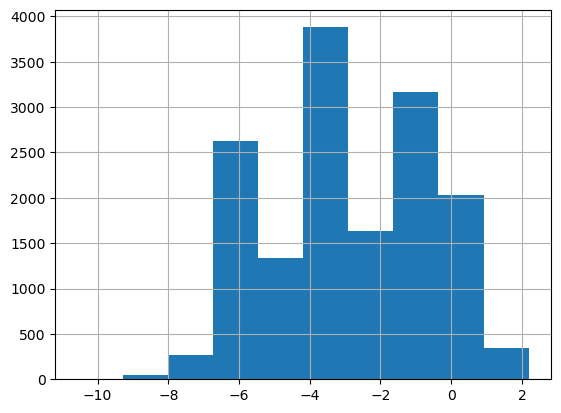

In [236]:
score_to_check = "score_weighted_by_sub"

test_discomfort_w = test_Gw[score_to_check]

test_discomfort_w.hist()

In [237]:
test_Gw.sort_values("score_weighted_by_sub", ascending=True).head(10)

,,,score_weighted_by_main,score_weighted_by_sub,SW_foot,SW_highway,SW_ALLEY,SW_width,SW_lit,SW_maxspeed,SW_segregated,SW_sidewalk,...,maxspeed_comp,segregated_comp,crossing_tag_comp,edsa_accident_comp,motor_vehicle_comp,highway,foot,footway,bicycle,cycleway
u,v,key,,,,,,,,,,,,,,,,,,,,,
394430786,1278924698,0,-10.559297,-10.559297,-2.0,-0.5,0.0,0.0,-1.0,-1.19,0.0,-4.0,...,-1,0,0,0,0,residential,yes,None,yes,None
1278924698,394430786,0,-10.559297,-10.559297,-2.0,-0.5,0.0,0.0,-1.0,-1.19,0.0,-4.0,...,-1,0,0,0,0,residential,yes,None,yes,None
6551956883,242433705,0,-9.135730,-9.135730,0.0,-0.5,0.0,0.0,-1.0,0.00,0.0,-4.0,...,0,0,0,0,0,residential,None,None,None,None
242433705,6551956883,0,-9.135730,-9.135730,0.0,-0.5,0.0,0.0,-1.0,0.00,0.0,-4.0,...,0,0,0,0,0,residential,None,None,None,None
334410575,6539056925,0,-8.998115,-8.998115,0.0,-0.5,0.0,0.0,-1.0,-1.19,0.0,-4.0,...,-1,0,0,0,0,residential,None,None,None,None
6539056925,334410575,0,-8.998115,-8.998115,0.0,-0.5,0.0,0.0,-1.0,-1.19,0.0,-4.0,...,-1,0,0,0,0,residential,None,None,None,None
9985683120,334410575,0,-8.961940,-8.961940,0.0,-0.5,0.0,0.0,-1.0,-1.19,0.0,-4.0,...,-1,0,0,0,0,residential,None,None,None,None
334410575,9985683120,0,-8.961940,-8.961940,0.0,-0.5,0.0,0.0,-1.0,-1.19,0.0,-4.0,...,-1,0,0,0,0,residential,None,None,None,None
12233670799,6451382998,0,-8.849624,-8.849624,0.0,0.0,0.0,0.0,-1.0,-1.19,0.0,-4.0,...,-1,0,0,0,0,tertiary,None,None,None,None


### maps

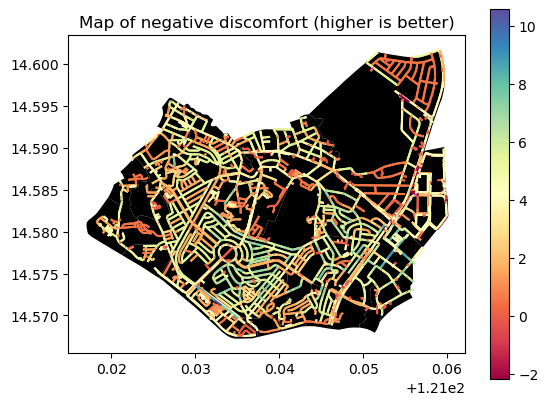

In [238]:
fig, ax = plt.subplots()

# city
brgy_geo_for_city.plot(aspect = 1, ax = ax, color = "black")

# thing being tested
Gw_edges.plot(-test_discomfort_w, aspect = 1, ax = ax, legend = True, cmap = chosen_cmap)

plt.title("Map of negative discomfort (higher is better)")
plt.show()

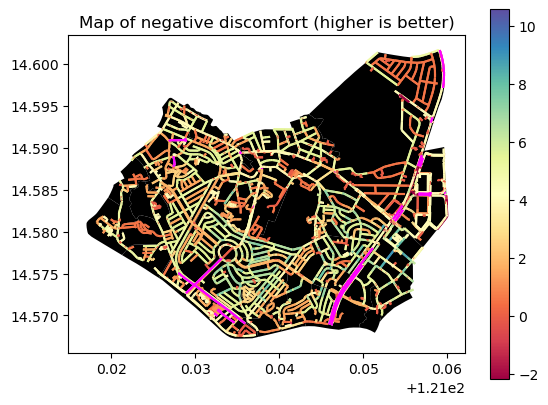

In [239]:
fig, ax = plt.subplots()

# city
brgy_geo_for_city.plot(aspect = 1, ax = ax, color = "black")

# thing being tested
Gw_edges.plot(-test_discomfort_w, aspect = 1, ax = ax, legend = True, cmap = chosen_cmap)

# # Mark red the streets of interest
Gw_edges.loc[Gw_edges["foot"].isin(["yes", "designated"])].plot(aspect = 1, ax = ax, color = "magenta")
# Gw_edges.loc[Gw_edges["highway"].isin(["residential"])].plot(aspect = 1, ax = ax, color = "red")

plt.title("Map of negative discomfort (higher is better)")
plt.show()

# Export for val

In [240]:
cols_to_exclude = [
    'sidewalk_description',
    'has_left_sidewalk_status', 'has_right_sidewalk_status',
    'is_crossing_status', 'bicycle_status', 'cycleway_lane_type',
    'cycleway_description', 'cycleway_left_lane_type',
    'cycleway_right_lane_type', 'cycleway_class', 'cycleway_left_class',
    'cycleway_right_class', 'parking_left_description',
    'parking_right_description', 'width_comp', 'lit_comp', 'maxspeed_comp',
    'segregated_comp', 'crossing_tag_comp', 'edsa_accident_comp',
    'motor_vehicle_comp', 'highway', 'foot', 'footway', 'bicycle',
    'cycleway'
]

test_Gb_for_export = (
    Gb_edges.apply(
        lambda s: biking_discomfort(
            s,
            weights = default_weights_Gb_CYCLE,
            weights_main_components = default_weights_main_components_Gb,
        ),
        axis = 1
    )
    .merge(preproc_Gb, left_index = True, right_index = True)
)
test_Gb_for_export = test_Gb_for_export.loc[
    :,
    [
        col for col in test_Gb_for_export
        if all([not col.startswith(prefix) for prefix in ("SW_", "MW_")])
        and (col not in cols_to_exclude)
    ]
]

test_Gw_for_export = (
    Gw_edges.apply(
        lambda s: walking_discomfort(
            s,
            weights = default_weights_Gw,
            weights_main_components = default_weights_main_components_Gw,
        ),
        axis = 1
    )
    .merge(preproc_Gw, left_index = True, right_index = True)
)
test_Gw_for_export = test_Gw_for_export.loc[
    :,
    [
        col for col in test_Gw_for_export
        if all([not col.startswith(prefix) for prefix in ("SW_", "MW_")])
        and (col not in cols_to_exclude)
    ]
]

test_Gb_for_export.columns

Index(['score_weighted_by_main', 'score_weighted_by_sub', 'SU_bicycle',
       'SU_CYCLEWAY_CLASS', 'SU_CYCLEWAY_LANE_TYPE', 'SU_foot', 'SU_highway',
       'SU_ALLEY', 'SU_width', 'SU_lit', 'SU_maxspeed', 'SU_segregated',
       'SU_sidewalk', 'SU_PARKING_SUBTAGS', 'SU_TAG_crossing',
       'SU_EDSA_accident_component', 'SU_motor_vehicle',
       'SU_FROM_IMAGES_cycling_lane_coverage', 'SU_FROM_IMAGES_greenery_ratio',
       'SU_FROM_IMAGES_has_bicycle', 'SU_FROM_IMAGES_road_condition',
       'MU_DISMOUNT', 'MU_convenience', 'MU_attractiveness',
       'MU_traffic_safety', 'MU_security', 'MU_accident_risk',
       'MU_traffic_volume', 'MU_safety_of_sidewalks_and_crossings'],
      dtype='object')

In [241]:
test_Gw_for_export.columns

Index(['score_weighted_by_main', 'score_weighted_by_sub', 'SU_foot',
       'SU_highway', 'SU_ALLEY', 'SU_width', 'SU_lit', 'SU_maxspeed',
       'SU_segregated', 'SU_sidewalk', 'SU_PARKING_SUBTAGS', 'SU_TAG_crossing',
       'SU_EDSA_accident_component', 'SU_motor_vehicle',
       'SU_FROM_IMAGES_sidewalk_ratio', 'SU_FROM_IMAGES_greenery_ratio',
       'SU_FROM_IMAGES_road_condition', 'SU_FROM_IMAGES_has_traffic_light',
       'SU_FROM_IMAGES_has_crosswalk', 'SU_FROM_IMAGES_obstruction_density',
       'MU_convenience', 'MU_traffic_volume', 'MU_traffic_speed',
       'MU_attractiveness', 'MU_accident_risk', 'MU_safety_of_sidewalks',
       'MU_safety_of_crossings'],
      dtype='object')

In [242]:
# # verify correct shape, and all are not null
test_Gw_for_export.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 15332 entries, (np.int64(321734921), np.int64(26365570), np.int32(0)) to (np.int64(6773491495), np.int64(6375475926), np.int32(0))
Data columns (total 27 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   score_weighted_by_main              15332 non-null  float64
 1   score_weighted_by_sub               15332 non-null  float64
 2   SU_foot                             15332 non-null  float64
 3   SU_highway                          15332 non-null  float64
 4   SU_ALLEY                            15332 non-null  float64
 5   SU_width                            15332 non-null  float64
 6   SU_lit                              15332 non-null  float64
 7   SU_maxspeed                         15332 non-null  float64
 8   SU_segregated                       15332 non-null  float64
 9   SU_sidewalk                         15332 non-null  float64
 10  S

In [243]:
test_Gb_for_export.to_csv("04_outputs/bike_discomfort_components.csv", index = True)
test_Gw_for_export.to_csv("04_outputs/walk_discomfort_components.csv", index = True)